## **Imports**

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from random import choice
from scipy import ndimage
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras import backend as K
import tensorflow as tf

tf.random.set_seed(0)

## **Montar en entorno de trabajo grupal de Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls

drive/  sample_data/


In [ ]:
working_dir = "/content/drive/MyDrive/TAC-TA/Data Augmentation"
%cd $working_dir

/content/drive/MyDrive/TAC-TA/Data Augmentation


## **Lectura de imágenes**

In [ ]:
path = 'Cerebral-Tumor-Images/'

In [ ]:
glioma_tumor_paths = [("./data/glioma_tumor/" + x) for x in os.listdir("./data/glioma_tumor")]

meningioma_tumor_paths = [("./data/meningioma_tumor/" + x) for x in os.listdir("./data/meningioma_tumor")]

no_tumor_paths = [("./data/no_tumor/" + x) for x in os.listdir("./data/no_tumor")]

pituitary_tumor_paths = [("./data/pituitary_tumor/" + x) for x in os.listdir("./data/pituitary_tumor")]

print("glioma_tumor scan with length of: {}".format(len(glioma_tumor_paths)))
print("meningioma_tumor scan with length of: {}".format(len(meningioma_tumor_paths)))
print("no_tumor scan with length of: {}".format(len(no_tumor_paths)))
print("pituitary_tumor scan with length of: {}".format(len(pituitary_tumor_paths)))

glioma_tumor scan with length of: 1000
meningioma_tumor scan with length of: 1000
no_tumor scan with length of: 1000
pituitary_tumor scan with length of: 1000


In [ ]:
glioma_tumor_paths[:5]

['./data/glioma_tumor/gg (190).jpg',
 './data/glioma_tumor/gg (794).jpg',
 './data/glioma_tumor/gg (732).jpg',
 './data/glioma_tumor/gg (468).jpg',
 './data/glioma_tumor/gg (470).jpg']

In [ ]:
meningioma_tumor_paths[:5]

['./data/meningioma_tumor/m1(171).jpg',
 './data/meningioma_tumor/m1(131).jpg',
 './data/meningioma_tumor/m1(114).jpg',
 './data/meningioma_tumor/m3 (206).jpg',
 './data/meningioma_tumor/m3 (96).jpg']

In [ ]:
no_tumor_paths[:5]

['./data/no_tumor/image(256).jpg',
 './data/no_tumor/image(295).jpg',
 './data/no_tumor/image(127).jpg',
 './data/no_tumor/image(19).jpg',
 './data/no_tumor/image(400).jpg']

In [ ]:
pituitary_tumor_paths[:5]

['./data/pituitary_tumor/image(61).jpg',
 './data/pituitary_tumor/p (544).jpg',
 './data/pituitary_tumor/p (824).jpg',
 './data/pituitary_tumor/p (511).jpg',
 './data/pituitary_tumor/p (658).jpg']

Asignar las etiquetas a las tomografías computarizadas

no_tumor Scans -> 0

meningioma_tumor Scans -> 1

glioma_tumorglioma_tumor Scans -> 2

pituitary_tumor Scans -> 3

In [ ]:
preprocess_image = tf.keras.Sequential([
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2, fill_mode='constant'),
  tf.keras.layers.RandomCrop(180,180),
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.RandomContrast(0.5)
])

In [ ]:
def augment_image(path):
  im = Image.open(path)
  im = im.resize((224, 224))

  x = np.asarray(im, np.float32)
  x = x[None]

  x = data_augmentation(x)

  x = x.numpy().reshape(224,224,3)

  x = x.astype(np.uint8)

  return Image.fromarray(x)

## **Image Augmentation: Nivelar distribución a 1000 por clase**.

In [ ]:
import random

for index, img_path in enumerate(random.sample(no_tumor_paths, 1000 - len(no_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/no_tumor/AG_({}).jpg'.format(index+1))

In [ ]:
import random

for index, img_path in enumerate(random.sample(glioma_tumor_paths, 1000 - len(glioma_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/glioma_tumor/AG_({}).jpg'.format(index+1))

In [ ]:
for index, img_path in enumerate(random.sample(meningioma_tumor_paths, 1000 - len(meningioma_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/meningioma_tumor/AG_1({}).jpg'.format(index+1))

In [ ]:
for index, img_path in enumerate(random.sample(pituitary_tumor_paths, 1000 - len(pituitary_tumor_paths))):
  augmented = augment_image(img_path)
  augmented.save('./data/pituitary_tumor/AG_({}).jpg'.format(index+1))

## **Lectura de dataset desde directorio**

In [ ]:
img_size = 224
batch_size = 64
path = 'data'

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    path, 
    target_size=(img_size, img_size), 
    shuffle=True, 
    color_mode="rgb", 
    class_mode="sparse", 
    batch_size=batch_size, 
    subset="training")
validation_generator = train_datagen.flow_from_directory(
    path, 
    target_size=(img_size, img_size), 
    shuffle=False, 
    color_mode="rgb", 
    class_mode="sparse", 
    batch_size=batch_size, 
    subset="validation")

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


## **Modelo Inicial: Red clásica convolucional de clase**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, ReLU, Flatten, Dense, BatchNormalization, Dropout #Aquí van el resto de capas que se necesiten para construir el modelo
from tensorflow.keras import Model

K.clear_session()

inputs = Input(shape=(224, 224, 3))

convolutional_1 = Conv2D(16, kernel_size=(3,3), padding="same")(inputs)

max_pooling_1 = MaxPool2D(pool_size=(2,2))(convolutional_1)

relu_1 = ReLU()(max_pooling_1)

convolutional_2 = Conv2D(32, kernel_size=(3,3), padding="same")(relu_1)

max_pooling_2 = MaxPool2D(pool_size=(2,2))(convolutional_2)

relu_2 = ReLU()(max_pooling_2)

convolutional_3 = Conv2D(64, kernel_size=(3,3))(relu_2)

relu_3 = ReLU()(convolutional_3)

flatten = Flatten()(relu_3)

dense = Dense(256, activation="relu")(flatten)

outputs = Dense(units=4, activation="softmax")(dense)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                         

In [ ]:
def show_results(log):
  loss = log.history['loss']
  acc = log.history['accuracy']

  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
  
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes

  ax1.plot(loss, label='train')
  ax1.plot(val_loss, label='test')
  
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  
  ax2.plot(acc, label='train')
  ax2.plot(val_acc, label='test')
  
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  
  for ax in axes: ax.legend()

## **Entrenamiento**

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
50/50 [==============================] - 30s 585ms/step - loss: 1.3678 - accuracy: 0.5675 - val_loss: 2.0719 - val_accuracy: 0.4162
Epoch 2/10
50/50 [==============================] - 28s 562ms/step - loss: 0.5552 - accuracy: 0.7875 - val_loss: 1.8158 - val_accuracy: 0.5700
Epoch 3/10
50/50 [==============================] - 28s 562ms/step - loss: 0.2745 - accuracy: 0.9072 - val_loss: 2.5430 - val_accuracy: 0.5512
Epoch 4/10
50/50 [==============================] - 28s 554ms/step - loss: 0.1242 - accuracy: 0.9594 - val_loss: 2.6238 - val_accuracy: 0.5575
Epoch 5/10
50/50 [==============================] - 28s 553ms/step - loss: 0.0566 - accuracy: 0.9862 - val_loss: 4.4398 - val_accuracy: 0.6100
Epoch 6/10
50/50 [==============================] - 28s 553ms/step - loss: 0.0383 - accuracy: 0.9891 - val_loss: 3.7264 - val_accuracy: 0.6075
Epoch 7/10
50/50 [==============================] - 27s 550ms/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 5.3765 - val_accuracy: 0.5838

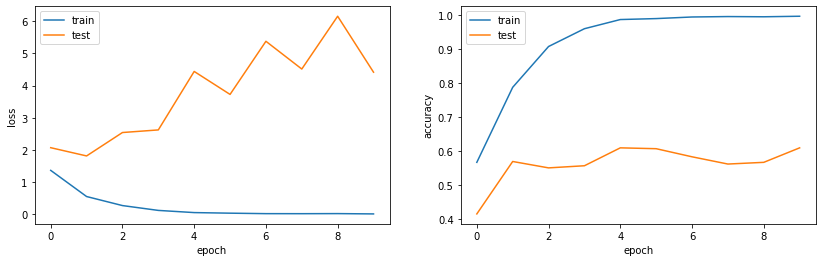

In [ ]:
show_results(log)

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
50/50 [==============================] - 28s 554ms/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 5.2603 - val_accuracy: 0.5788
Epoch 2/20
50/50 [==============================] - 28s 562ms/step - loss: 0.0179 - accuracy: 0.9944 - val_loss: 6.0794 - val_accuracy: 0.5738
Epoch 3/20
50/50 [==============================] - 28s 555ms/step - loss: 0.0102 - accuracy: 0.9991 - val_loss: 5.5331 - val_accuracy: 0.5987
Epoch 4/20
50/50 [==============================] - 28s 555ms/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 5.8350 - val_accuracy: 0.6125
Epoch 5/20
50/50 [==============================] - 27s 545ms/step - loss: 0.0091 - accuracy: 0.9991 - val_loss: 5.0239 - val_accuracy: 0.6050
Epoch 6/20
50/50 [==============================] - 27s 550ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 5.5785 - val_accuracy: 0.5825
Epoch 7/20
50/50 [==============================] - 27s 548ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 5.6676 - val_accuracy: 0.5863

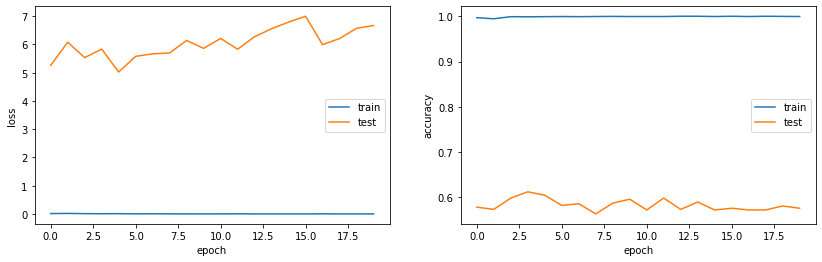

In [ ]:
show_results(log)

## **Modelo Inicial Mejorado**

In [ ]:
def create_model_v1():

  K.clear_session()

  inputs = Input(shape=(224, 224, 3))

  convolutional_1 = Conv2D(64, kernel_size=(3,3), padding="same", kernel_initializer='he_uniform', use_bias=False, kernel_regularizer='l2')(inputs)

  max_pooling_1 = MaxPool2D(pool_size=(2,2))(convolutional_1)

  relu_1 = ReLU()(max_pooling_1)

  bn_1 = BatchNormalization()(relu_1)

  convolutional_2 = Conv2D(64, kernel_size=(3,3), padding="same", kernel_initializer='he_uniform', use_bias=False, kernel_regularizer='l2')(bn_1)

  max_pooling_2 = MaxPool2D(pool_size=(2,2))(convolutional_2)

  relu_2 = ReLU()(max_pooling_2)

  bn_2 = BatchNormalization()(relu_2)

  convolutional_3 = Conv2D(64, kernel_size=(3,3), kernel_initializer='he_uniform', use_bias=False, kernel_regularizer='l2')(bn_2)

  relu_3 = ReLU()(convolutional_3)

  bn_3 = BatchNormalization()(relu_3)

  flatten = Flatten()(bn_3)

  dense1 = Dense(256, activation="relu", kernel_initializer='he_uniform', kernel_regularizer='l2')(flatten)

  dp = Dropout(0.2)(dense1)

  dense2 = Dense(256, activation="relu", kernel_initializer='he_uniform', kernel_regularizer='l2')(dp)

  outputs = Dense(units=4, kernel_initializer='he_uniform', activation="softmax")(dense2)

  return Model(inputs=inputs, outputs=outputs)

model = create_model_v1()

model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 112, 112, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36864 

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
50/50 [==============================] - 31s 611ms/step - loss: 28.5520 - accuracy: 0.5900 - val_loss: 42.0045 - val_accuracy: 0.2625
Epoch 2/10
50/50 [==============================] - 30s 606ms/step - loss: 21.0404 - accuracy: 0.6209 - val_loss: 30.8744 - val_accuracy: 0.2525
Epoch 3/10
50/50 [==============================] - 31s 612ms/step - loss: 15.0159 - accuracy: 0.6881 - val_loss: 21.3777 - val_accuracy: 0.2612
Epoch 4/10
50/50 [==============================] - 30s 598ms/step - loss: 12.1423 - accuracy: 0.7081 - val_loss: 23.9665 - val_accuracy: 0.2675
Epoch 5/10
50/50 [==============================] - 30s 598ms/step - loss: 11.1064 - accuracy: 0.7266 - val_loss: 35.2815 - val_accuracy: 0.2562
Epoch 6/10
50/50 [==============================] - 30s 600ms/step - loss: 11.3094 - accuracy: 0.7250 - val_loss: 20.3303 - val_accuracy: 0.3525
Epoch 7/10
50/50 [==============================] - 30s 608ms/step - loss: 11.5440 - accuracy: 0.7256 - val_loss: 21.2439 - val_ac

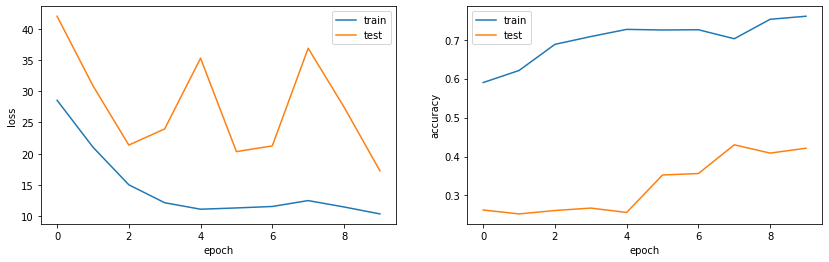

In [ ]:
show_results(log)

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
50/50 [==============================] - 30s 608ms/step - loss: 10.0150 - accuracy: 0.8012 - val_loss: 25.9968 - val_accuracy: 0.4313
Epoch 2/10
50/50 [==============================] - 30s 596ms/step - loss: 9.2987 - accuracy: 0.8188 - val_loss: 18.9252 - val_accuracy: 0.4863
Epoch 3/10
50/50 [==============================] - 30s 608ms/step - loss: 10.3197 - accuracy: 0.7947 - val_loss: 24.4847 - val_accuracy: 0.5213
Epoch 4/10
50/50 [==============================] - 30s 594ms/step - loss: 10.5981 - accuracy: 0.8188 - val_loss: 72.0970 - val_accuracy: 0.5025
Epoch 5/10
50/50 [==============================] - 30s 596ms/step - loss: 7.7621 - accuracy: 0.8678 - val_loss: 28.3146 - val_accuracy: 0.5175
Epoch 6/10
50/50 [==============================] - 30s 593ms/step - loss: 6.5274 - accuracy: 0.8853 - val_loss: 21.2623 - val_accuracy: 0.4187
Epoch 7/10
50/50 [==============================] - 30s 601ms/step - loss: 7.4324 - accuracy: 0.8687 - val_loss: 22.4016 - val_accura

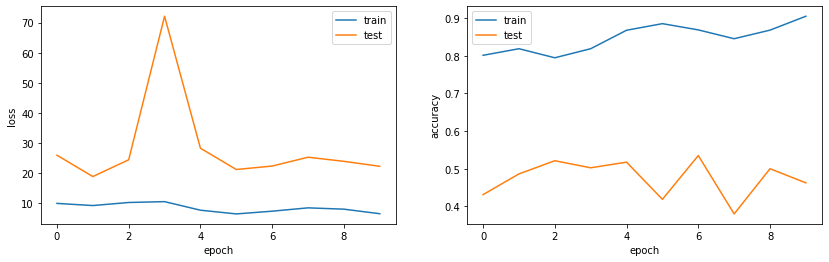

In [ ]:
show_results(log)

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
50/50 [==============================] - 31s 615ms/step - loss: 6.1767 - accuracy: 0.9181 - val_loss: 29.0005 - val_accuracy: 0.4450
Epoch 2/10
50/50 [==============================] - 31s 615ms/step - loss: 7.0919 - accuracy: 0.9109 - val_loss: 21.5687 - val_accuracy: 0.5400
Epoch 3/10
50/50 [==============================] - 30s 597ms/step - loss: 6.3352 - accuracy: 0.9191 - val_loss: 26.1778 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 30s 591ms/step - loss: 8.3832 - accuracy: 0.8956 - val_loss: 21.3658 - val_accuracy: 0.5362
Epoch 5/10
50/50 [==============================] - 31s 620ms/step - loss: 6.3045 - accuracy: 0.9353 - val_loss: 15.9482 - val_accuracy: 0.5725
Epoch 6/10
50/50 [==============================] - 30s 593ms/step - loss: 4.7933 - accuracy: 0.9563 - val_loss: 9.3908 - val_accuracy: 0.5725
Epoch 7/10
50/50 [==============================] - 30s 592ms/step - loss: 4.0123 - accuracy: 0.9631 - val_loss: 8.1990 - val_accuracy: 0

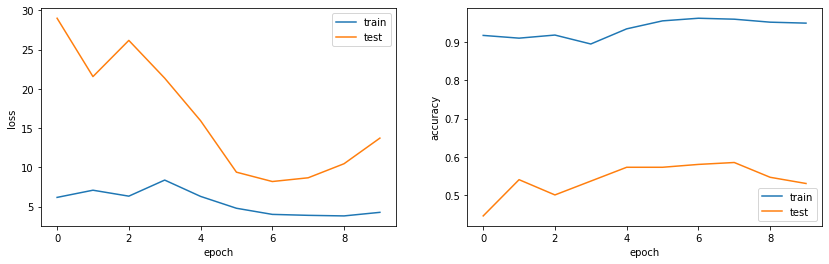

In [ ]:
show_results(log)

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
50/50 [==============================] - 31s 616ms/step - loss: 4.5402 - accuracy: 0.9525 - val_loss: 9.4926 - val_accuracy: 0.5962
Epoch 2/10
50/50 [==============================] - 30s 594ms/step - loss: 4.3857 - accuracy: 0.9559 - val_loss: 11.3610 - val_accuracy: 0.5425
Epoch 3/10
50/50 [==============================] - 30s 597ms/step - loss: 3.6511 - accuracy: 0.9616 - val_loss: 7.5339 - val_accuracy: 0.5987
Epoch 4/10
50/50 [==============================] - 30s 602ms/step - loss: 3.0537 - accuracy: 0.9709 - val_loss: 6.6188 - val_accuracy: 0.5738
Epoch 5/10
50/50 [==============================] - 30s 600ms/step - loss: 2.9541 - accuracy: 0.9622 - val_loss: 7.7660 - val_accuracy: 0.5600
Epoch 6/10
50/50 [==============================] - 30s 599ms/step - loss: 2.7740 - accuracy: 0.9681 - val_loss: 6.7470 - val_accuracy: 0.5700
Epoch 7/10
50/50 [==============================] - 30s 600ms/step - loss: 2.5969 - accuracy: 0.9734 - val_loss: 6.9927 - val_accuracy: 0.597

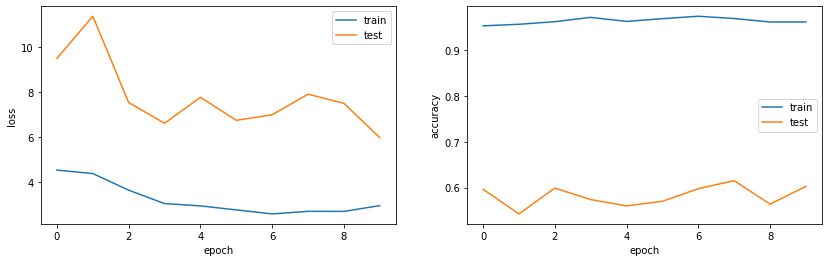

In [ ]:
show_results(log)

In [ ]:
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling="avg")
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
def create_model_v2(resnet):

  tf.random.set_seed(0)

  K.clear_session()

  input_layer = resnet.input

  den_resnet = resnet(input_layer)

  dense1 = Dense(512, activation="relu", kernel_initializer='he_uniform', kernel_regularizer='l2')(den_resnet)
  dp = Dropout(0.2)(dense1)

  dense2 = Dense(256, activation="relu", kernel_initializer='he_uniform', kernel_regularizer='l2')(dp)
  dp = Dropout(0.2)(dense2)

  outputs = Dense(units=4, kernel_initializer='he_uniform', activation="softmax")(dp)

  return Model(inputs=input_layer, outputs=outputs)

In [ ]:
model = create_model_v2(base_model)

model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1028  

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
50/50 [==============================] - 713s 14s/step - loss: 15.4080 - accuracy: 0.2925 - val_loss: 13.9076 - val_accuracy: 0.2650
Epoch 2/10
50/50 [==============================] - 620s 12s/step - loss: 12.7456 - accuracy: 0.3319 - val_loss: 11.6320 - val_accuracy: 0.3475
Epoch 3/10
50/50 [==============================] - 622s 12s/step - loss: 10.6860 - accuracy: 0.3541 - val_loss: 9.8378 - val_accuracy: 0.3125
Epoch 4/10
50/50 [==============================] - 626s 13s/step - loss: 9.0231 - accuracy: 0.3891 - val_loss: 8.4072 - val_accuracy: 0.3388
Epoch 5/10
50/50 [==============================] - 622s 12s/step - loss: 7.7106 - accuracy: 0.4150 - val_loss: 7.2765 - val_accuracy: 0.3388
Epoch 6/10
50/50 [==============================] - 621s 12s/step - loss: 6.6640 - accuracy: 0.4250 - val_loss: 6.3650 - val_accuracy: 0.3388
Epoch 7/10
50/50 [==============================] - 624s 13s/step - loss: 5.8178 - accuracy: 0.4494 - val_loss: 5.6492 - val_accuracy: 0.3400
E

In [ ]:
log = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
50/50 [==============================] - 634s 13s/step - loss: 8.3317 - accuracy: 0.3278 - val_loss: 4.0749 - val_accuracy: 0.2988
Epoch 2/20
50/50 [==============================] - 630s 13s/step - loss: 3.1112 - accuracy: 0.4116 - val_loss: 2.7313 - val_accuracy: 0.3137
Epoch 3/20
50/50 [==============================] - 645s 13s/step - loss: 2.3066 - accuracy: 0.4156 - val_loss: 2.3436 - val_accuracy: 0.3587
Epoch 4/20
50/50 [==============================] - 627s 13s/step - loss: 1.9385 - accuracy: 0.4475 - val_loss: 2.1539 - val_accuracy: 0.3237
Epoch 5/20
50/50 [==============================] - 630s 13s/step - loss: 1.7232 - accuracy: 0.4647 - val_loss: 1.8791 - val_accuracy: 0.3275
Epoch 6/20
50/50 [==============================] - 647s 13s/step - loss: 1.5776 - accuracy: 0.4834 - val_loss: 1.7944 - val_accuracy: 0.3237
Epoch 7/20
50/50 [==============================] - 633s 13s/step - loss: 1.4430 - accuracy: 0.5409 - val_loss: 1.8347 - val_accuracy: 0.3688
Epoch 